In [1]:
import diff_classifier.aws as aws
import diff_classifier.utils as ut
import diff_classifier.msd as msd
import diff_classifier.features as ft
import diff_classifier.imagej as ij
import diff_classifier.heatmaps as hm
import os
import os.path as op
import numpy as np
import numpy.ma as ma
import scipy.stats as stats
import pandas as pd
import boto3
import skimage.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

# Loading and checking a video

In [6]:
test_image = sio.imread('{}_3_3.tif'.format(prefix))

(-0.5, 2047.5, 2043.5, -0.5)

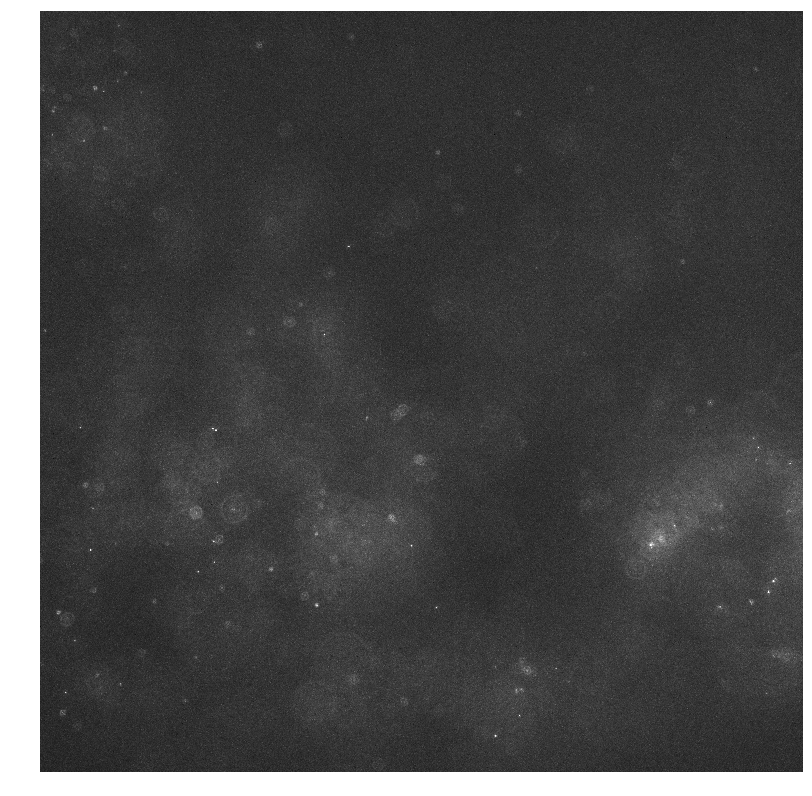

In [7]:
aws.download_s3('{}/{}.tif'.format(remote_folder, prefix), '{}.tif'.format(prefix))

fig, ax = plt.subplots(figsize=(14, 14))
full_image = sio.imread('{}.tif'.format(prefix))
ax.imshow(full_image[650, :, :], cmap='gray', vmin=60, vmax=500)
ax.axis('off')

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(test_image[650, :, :], cmap='gray', vmin=60, vmax=300)

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(test_image[0, :, :], cmap='gray', vmin=60, vmax=300)

# Splitting images before analysis

In [2]:
prefix = 'P2_S1_R_0010'
remote_folder = "01_18_Experiment/{}".format(prefix.split('_')[0])
local_folder = os.getcwd()
ires = 512
frames = 651
filename = '{}.tif'.format(prefix)
remote_name = op.join(remote_folder, filename)
local_name = op.join(local_folder, filename)

s3 = boto3.client('s3')

In [ ]:
remote_folder

In [ ]:
#ij.partition_im?

In [3]:
names = []
for i in range(0, 4):
    for j in range(0, 4):
        names.append('{}_{}_{}.tif'.format(prefix, i, j))

try:
    for name in names:
        aws.download_s3(remote_folder+'/'+name, name)
except:
    aws.download_s3(remote_name, local_name)
    names = ij.partition_im(local_name)
    for name in names:
        #aws.upload_s3(name, op.join(remote_folder, name))
        print("Done with splitting.  Should output file of name {}".format(remote_folder+'/'+name))

# Particle Tracking

Pause here to demonstrate tracking with the Trackmate GUI.  Show the Trackmate template file.

In [ ]:
#ij.track?

In [ ]:
# outfile = 'Traj_' + names[15].split('.')[0] + '.csv'
# row = int(names[15].split('.')[0].split('_')[4])
# local_im = op.join(local_folder, names[15])
# row=3

# test_intensity = ij.mean_intensity(local_im)
# if test_intensity > 500:
#     quality = 245
# else:
#     quality = 4.5
    
# if row==3:
#     y = 500
# else:
#     y = 511

# ij.track(local_im, outfile, template=None, fiji_bin=None, radius=4.5, threshold=0., 
#       do_median_filtering=True, quality=quality, x=511, y=y, ylo=1, median_intensity=300.0, snr=0.0, 
#       linking_max_distance=8.0, gap_closing_max_distance=10.0, max_frame_gap=2,
#       track_displacement=10.0)

In [4]:
for name in names:
    outfile = 'Traj_' + name.split('.')[0] + '.csv'
    local_im = op.join(local_folder, name)
    
    row = int(name.split('.')[0].split('_')[4])
    col = int(name.split('.')[0].split('_')[5])

#     try:
#         aws.download_s3(remote_folder+'/'+outfile, outfile)
#     except:
    test_intensity = ij.mean_intensity(local_im)
    if test_intensity > 500:
        quality = 245
    else:
        quality = 4.5
        
    if row==3:
        y = 485
    else:
        y = 511

    ij.track(local_im, outfile, template=None, fiji_bin=None, radius=4.5, threshold=0., 
          do_median_filtering=True, quality=quality, x=511, y=y, ylo=1, median_intensity=300.0, snr=0.0, 
          linking_max_distance=8.0, gap_closing_max_distance=10.0, max_frame_gap=2,
          track_displacement=10.0)

    aws.upload_s3(outfile, remote_folder+'/'+outfile)
    print("Done with tracking.  Should output file of name {}".format(remote_folder+'/'+outfile))

/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmph2efu5lp.py
Done with tracking.  Should output file of name 01_18_Experiment/P2/Traj_P2_S1_R_0010_0_0.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmptt2r8p0i.py
Done with tracking.  Should output file of name 01_18_Experiment/P2/Traj_P2_S1_R_0010_0_1.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpwb4ajv2c.py
Done with tracking.  Should output file of name 01_18_Experiment/P2/Traj_P2_S1_R_0010_0_2.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpr63wj1a2.py
Done with tracking.  Should output file of name 01_18_Experiment/P2/Traj_P2_S1_R_0010_0_3.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmpceqreht0.py
Done with tracking.  Should output file of name 01_18_Experiment/P2/Traj_P2_S1_R_0010_1_0.csv
/home/ubuntu/Fiji.app/ImageJ-linux64 --ij2 --headless --run /tmp/tmp_yzc1kpc.py
Done with tracking.  Should output file of name 01

# Calculating MSDs and Features

In [ ]:
#msd.all_msds2?

In [ ]:
# filename = "Traj_{}_{}_{}.csv".format(prefix, row, col)
# local_name = local_folder+'/'+filename

# merged = msd.all_msds2(ut.csv_to_pd(local_name), frames=frames)

In [ ]:
# merged

In [ ]:
# merged_ft = ft.calculated_features(merged)

In [ ]:
# merged_ft

In [5]:
msd_file = 'msd_{}.csv'.format(prefix)
ft_file = 'features_{}.csv'.format(prefix)

counter = 0
for name in names:
    row = int(name.split('.')[0].split('_')[4])
    col = int(name.split('.')[0].split('_')[5])

    filename = "Traj_{}_{}_{}.csv".format(prefix, row, col)
    local_name = local_folder+'/'+filename

    if counter == 0:
        to_add = ut.csv_to_pd(local_name)
        to_add['X'] = to_add['X'] + ires*col
        to_add['Y'] = ires - to_add['Y'] + ires*(3-row)
        merged = msd.all_msds2(to_add, frames=frames)
    else: 

        if merged.shape[0] > 0:
            to_add = ut.csv_to_pd(local_name)
            to_add['X'] = to_add['X'] + ires*col
            to_add['Y'] = ires - to_add['Y'] + ires*(3-row)
            to_add['Track_ID'] = to_add['Track_ID'] + max(merged['Track_ID']) + 1
        else:
            to_add = ut.csv_to_pd(local_name)
            to_add['X'] = to_add['X'] + ires*col
            to_add['Y'] = ires - to_add['Y'] + ires*(3-row)
            to_add['Track_ID'] = to_add['Track_ID']

        merged = merged.append(msd.all_msds2(to_add, frames=frames))
        print('Done calculating MSDs for row {} and col {}'.format(row, col))
    counter = counter + 1

merged.to_csv(msd_file)
aws.upload_s3(msd_file, remote_folder+'/'+msd_file)
merged_ft = ft.calculate_features(merged)
merged_ft.to_csv(ft_file)
aws.upload_s3(ft_file, remote_folder+'/'+ft_file)

Done calculating MSDs for row 0 and col 1
Done calculating MSDs for row 0 and col 2
Done calculating MSDs for row 0 and col 3
Done calculating MSDs for row 1 and col 0
Done calculating MSDs for row 1 and col 1
Done calculating MSDs for row 1 and col 2
Done calculating MSDs for row 1 and col 3
Done calculating MSDs for row 2 and col 0
Done calculating MSDs for row 2 and col 1
Done calculating MSDs for row 2 and col 2
Done calculating MSDs for row 2 and col 3
Done calculating MSDs for row 3 and col 0
Done calculating MSDs for row 3 and col 1
Done calculating MSDs for row 3 and col 2
Done calculating MSDs for row 3 and col 3
Optimal parameters not found. Print NaN instead.


/home/ubuntu/source/diff-classifier/diff_classifier/features.py:478: RuntimeWarning: divide by zero encountered in double_scalars
  ar = width/height


# Trajectory Visualization

In [ ]:
# merged = pd.read_csv('msd_{}.csv'.format(prefix))
# merged_ft = pd.read_csv('features_{}.csv'.format(prefix))

Plotted P2_S1_R_0010 trajectories successfully.


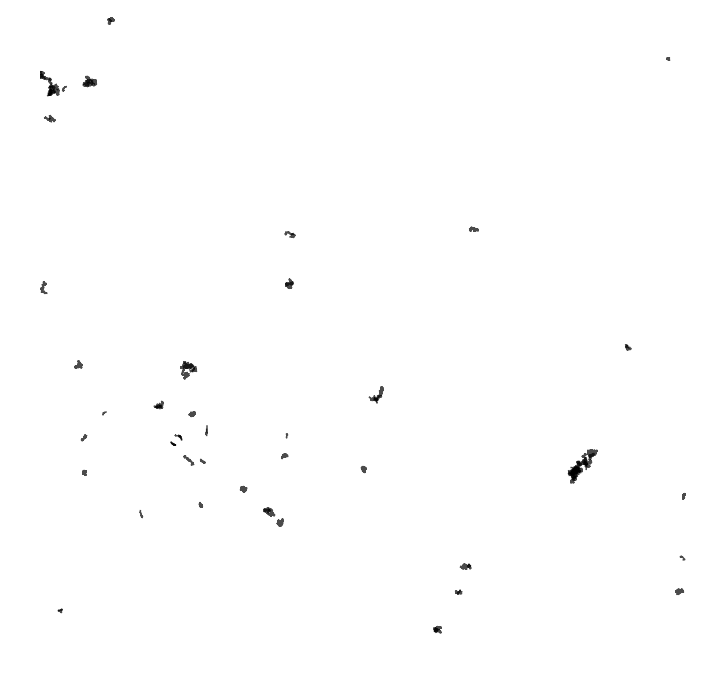

In [8]:
hm.plot_trajectories(prefix)

In [ ]:
# features = ('AR', 'D_fit', 'alpha', 'MSD_ratio', 'Track_ID', 'X', 'Y', 'asymmetry1', 'asymmetry2', 'asymmetry3',
#             'boundedness', 'efficiency', 'elongation', 'fractal_dim', 'frames', 'kurtosis', 'straightness', 'trappedness')

# for feature in features:
#     print('10th percentile of {}: {}'.format(feature, merged_ft[feature].quantile(0.1)))
#     print('90th percentile of {}: {}'.format(feature, merged_ft[feature].quantile(0.9)))
    
#     hm.plot_heatmap(prefix, feature=feature, vmin=merged_ft[feature].quantile(0.1), vmax=merged_ft[feature].quantile(0.9))

In [ ]:
# features = ('AR', 'D_fit', 'alpha', 'MSD_ratio', 'Track_ID', 'X', 'Y', 'asymmetry1', 'asymmetry2', 'asymmetry3',
#             'boundedness', 'efficiency', 'elongation', 'fractal_dim', 'frames', 'kurtosis', 'straightness', 'trappedness')
# vmin = (1.36, 0.015, 0.72, -0.09, 0, 0, 0, 0.5, 0.049, 0.089, 0.0069, 0.65, 0.26, 1.28, 0, 1.66, 0.087, -0.225)
# vmax = (3.98, 2.6, 2.3, 0.015, max(merged_ft['Track_ID']), 2048, 2048, 0.99, 0.415, 0.53, 0.062, 3.44, 0.75, 1.79, 650, 3.33, 0.52, -0.208)

# die = {'features': features,
#        'vmin': vmin,
#        'vmax': vmax}
# di = pd.DataFrame(data=die)

In [ ]:
# for i in range(0, di.shape[0]):
#     hm.plot_heatmap(prefix, feature=di['features'][i], vmin=di['vmin'][i], vmax=di['vmax'][i])
#     hm.plot_scatterplot(prefix, feature=di['features'][i], vmin=di['vmin'][i], vmax=di['vmax'][i])

Plotted P2_S1_R_0010 heatmap successfully.


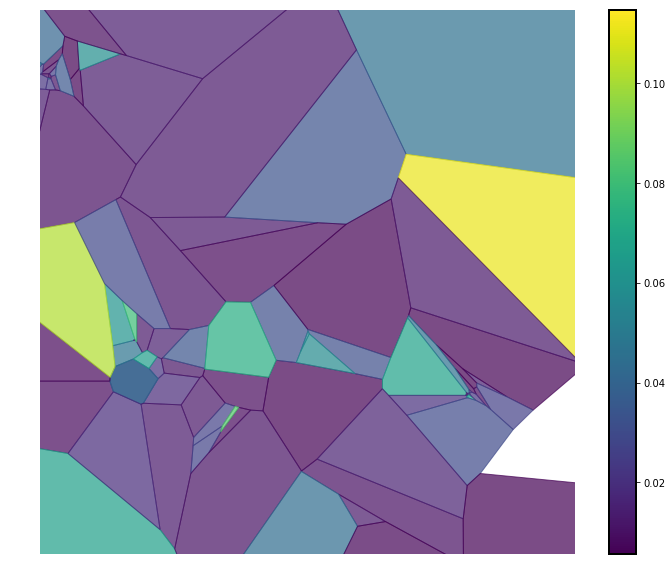

In [17]:
feature = 'boundedness'
hm.plot_heatmap(prefix, feature=feature, vmin=merged_ft[feature].quantile(0.1), vmax=merged_ft[feature].quantile(0.9))

In [15]:
ft.efficiency?

In [10]:
# fig, ax = plt.subplots(4, 4, figsize=(14, 14))
# for row in range(0, 2):
#     for col in range(0, 4):
#         subimage = sio.imread('{}_{}_{}.tif'.format(prefix, row, col))
#         ax[row, col].imshow(subimage[650, :, :], cmap='gray', vmin=60, vmax=500)
#         ax[row, col].axis('off')

Plotted P2_S1_R_0010 scatterplot successfully.


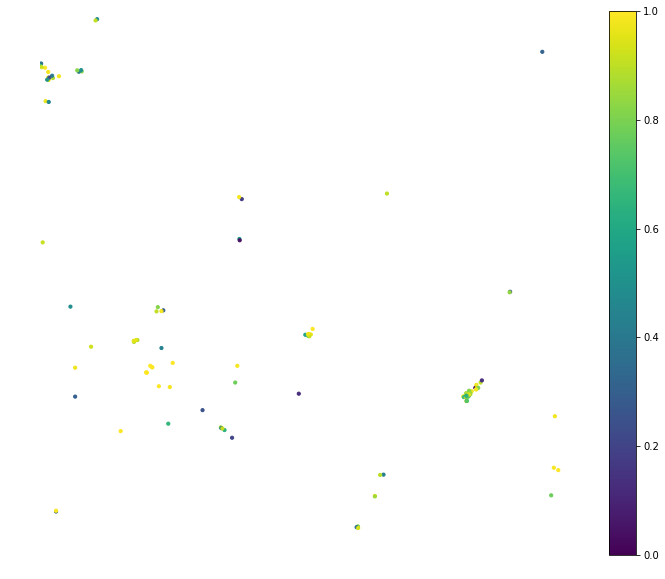

In [11]:
hm.plot_scatterplot(prefix)

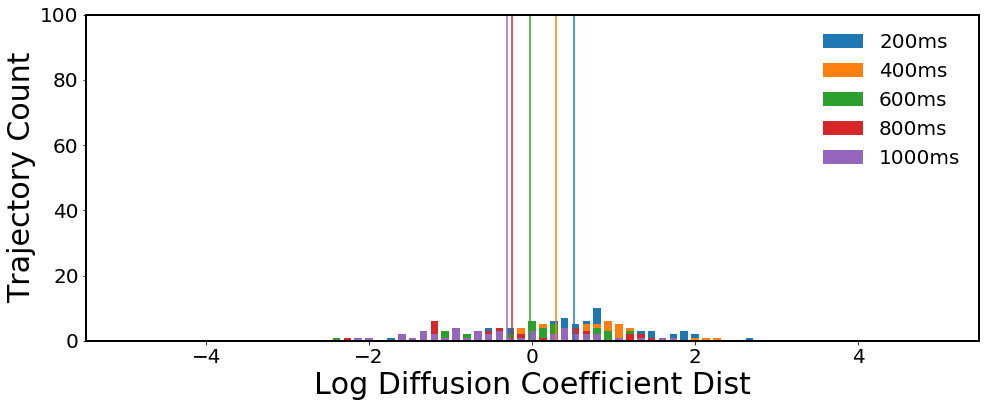

In [12]:
hm.plot_histogram(prefix)

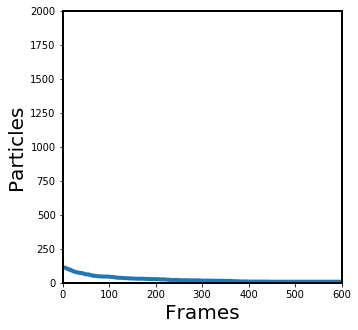

In [18]:
hm.plot_particles_in_frame(prefix)

/home/ubuntu/source/diff-classifier/diff_classifier/heatmaps.py:340: RuntimeWarning: divide by zero encountered in log
  geo_mean = np.nanmean(np.log(y), axis=0)
/home/ubuntu/source/diff-classifier/diff_classifier/heatmaps.py:341: RuntimeWarning: divide by zero encountered in log
  geo_SEM = stats.sem(np.log(y), axis=0, nan_policy='omit')


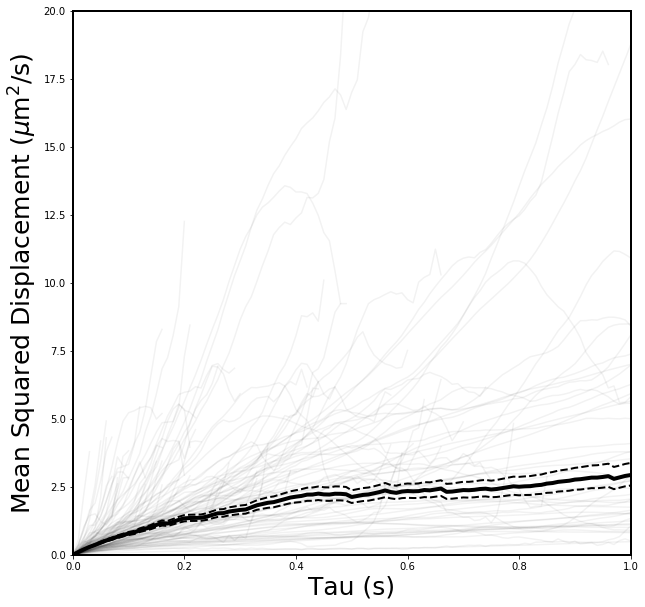

In [19]:
gmean1, gSEM1 = hm.plot_individual_msds(prefix, alpha=0.05)